In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "build")))

In [2]:
from cipells.experiments.continuous1d import *

In [3]:
import numpy as np
from matplotlib import pyplot, colors

In [4]:
%matplotlib notebook

In [5]:
positions = [-6.2, 7.4]
fluxes = [2.0, 3.0]

class ArrayPair:
    
    @classmethod
    def fromBounds(cls, x0, x1, **kwds):
        fine = np.linspace(x0 - 0.5, x1 + 0.5, 1 + 20*(x1 - x0))
        pixels = np.arange(x0, x1 + 1, dtype=int)
        return cls(fine=fine, pixels=pixels, **kwds)

    def __init__(self, fine, pixels):
        self.fine = fine
        self.pixels = pixels
        
    @property
    def bounds(self):
        return (self.pixels[0], self.pixels[-1])
        
class InputImage:
    
    def __init__(self, scaling, offset, sky, sigma=None, psf=None):
        self.sky = sky
        self.to_sky = AffineTransform(scaling=scaling, offset=offset)
        self.from_sky = self.to_sky.inverse
        self.frame = ArrayPair.fromBounds(x0=int(np.floor(self.from_sky(float(sky.bounds[0])))),
                                          x1=int(np.ceil(self.from_sky(float(sky.bounds[-1])))))
        if psf is None:
            self.psf = GaussianPixelConvolution(Gaussian(scaling=sigma), Pixel())
        else:
            self.psf = psf
        self.data = ArrayPair(pixels=np.zeros(self.frame.pixels.shape, dtype=float),
                              fine=np.zeros(self.frame.fine.shape, dtype=float))
        for p, f in zip(positions, fluxes):
            self.data.pixels[:] += self.psf(self.frame.pixels - self.from_sky(p))*f
            self.data.fine[:] += self.psf(self.frame.fine - self.from_sky(p))*f

        self.noise = 0.05*np.random.randn(*self.data.pixels.shape)
        self.noise[:32] = 0
        self.noise[-32:] = 0
            
    def project(self, data=None):
        if data is None:
            data = self.data.pixels
        s = self.psf(np.subtract.outer(self.frame.pixels, self.from_sky(self.sky.pixels)))
        return Accumulation(phi=np.dot(s.transpose(), s), psi=np.dot(data, s)/self.to_sky.scaling)
    
    def decorrelate(self, psi, maxk_threshold=None):
        cpsf = self.psf.transformedBy(self.to_sky)
        n = len(self.sky.pixels)
        x = np.concatenate([np.arange(0, n, dtype=float), np.arange(-n, 0, dtype=float)])
        assert(len(x) == 2*n)
        s = cpsf(x)
        fs = np.fft.rfft(s)
        fpsi = np.fft.rfft(psi, 2*n)
        fz = fpsi/fs
        if maxk_threshold is not None:
            fz[fs/fs.max() < maxk_threshold] = 0.0
        return np.fft.irfft(fz, 2*n)[:n].copy()

    def plot(self, title, full=True, maxk_threshold=None):
        if full:
            pyplot.subplot2grid((4, 9), (0, 0), colspan=9)
        else:
            pyplot.subplot2grid((2, 1), (0, 0))
        pyplot.plot(self.frame.pixels, self.data.pixels, ".", label='signal')
        pyplot.plot(self.frame.fine, self.data.fine, alpha=0.5, label='signal (fine)')
        pyplot.plot(self.frame.pixels, self.noise, "-", alpha=0.5, label='noise')
        pyplot.xlim(*self.frame.bounds)
        pyplot.legend(loc='upper right')
        pyplot.ylabel("input data")
        pyplot.ylim(-0.25, 0.75)
        
        if full:
            pyplot.subplot2grid((4, 9), (1, 0), colspan=9)
        else:
            pyplot.subplot2grid((2, 1), (1, 0))
        proj = self.project()
        noise_proj = self.project(self.noise)
        z = self.decorrelate(proj.psi, maxk_threshold=maxk_threshold)
        noise = self.decorrelate(noise_proj.psi, maxk_threshold=maxk_threshold)
        cpsf = self.psf.transformedBy(self.to_sky)
        zfine = np.zeros(self.sky.fine.shape, dtype=float)
        for p, f in zip(positions, fluxes):
            zfine[:] += cpsf(self.sky.fine - p)*f
        pyplot.plot(self.sky.pixels, z, ".", label='signal (resampled)')
        pyplot.plot(self.sky.fine, zfine, alpha=0.5, label='signal (predicted)')
        pyplot.plot(self.sky.pixels, noise, "-", alpha=0.5, label='noise')
        pyplot.plot(self.sky.pixels, proj.psi, ".", label='$\Psi$')
        pyplot.legend(loc='upper right')
        pyplot.xlim(self.to_sky(self.frame.bounds[0]), self.to_sky(self.frame.bounds[-1]))
        pyplot.ylabel("coadd")
        pyplot.ylim(-0.25, 0.75)
        
        if not full:
            if maxk_threshold is None:
                pyplot.savefig("{}-None.png".format(title))
                return
            else:
                pyplot.savefig("{}-{:0.2f}.png".format(title, -np.log10(maxk_threshold)))
                return

        norm = colors.SymLogNorm(1E-12, vmin=-1.0, vmax=1.0)
        pyplot.subplot2grid((4, 9), (2, 0), colspan=4, rowspan=2)
        pyplot.imshow(proj.phi, interpolation='nearest', origin='upper', norm=norm)
        pyplot.xlabel(r"$\Phi$")
        pyplot.subplot2grid((4, 9), (2, 4), colspan=4, rowspan=2)
        avg, delta = proj.mean_phi()
        pyplot.imshow(delta, interpolation='nearest', origin='upper', norm=norm)
        pyplot.xlabel(r"$\Phi$ - mean($\Phi$)")
        cax = pyplot.subplot2grid((4, 9), (2, 8), rowspan=2)
        cb = pyplot.colorbar(cax=cax)
        cb.set_ticks([-1, -1E-4, -1E-8, -1E-12, 1E-12, 1E-8, 1E-4, 1])
        pyplot.subplots_adjust(wspace=2.0, hspace=0.5)
        pyplot.savefig(title + ".png")

class Accumulation:
    
    def __init__(self, phi, psi):
        self.phi = phi
        self.psi = psi

    def mean_phi(self, radius=40):
        n = self.phi.shape[0]
        avg = np.zeros(radius*2 + 1, dtype=float)
        for i in range(radius, n - radius):
            avg += self.phi[i, i - radius:i + radius + 1]
        avg /= (n - 2*radius)
        delta = self.phi.copy()
        for i in range(0, n):
            lo = -radius if i >= radius else -i
            hi = radius + 1 if i < n - radius else n - i
            delta[i, i + lo: i + hi] -= avg[radius + lo: radius + hi]
        return avg, delta
    
    def __iadd__(self, other):
        self.phi += other.phi
        self.psi += other.psi
        return self

In [6]:
sky = ArrayPair.fromBounds(-128, 128)

<IPython.core.display.Javascript object>


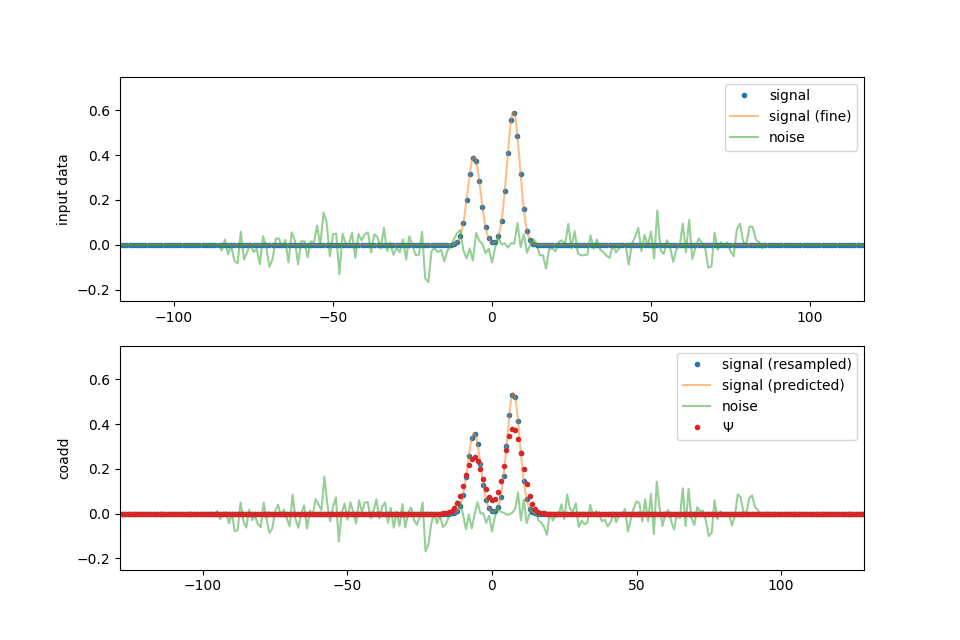

In [7]:
pyplot.figure(figsize=(9.6, 6.4))
InputImage(sigma=2.0, scaling=1.1, offset=0.0, sky=sky).plot("well-sampled-110-scaling", full=False,
                                                             maxk_threshold=None)

In [ ]:
input1 = InputImage(sigma=0.2, scaling=5.0, offset=4.0, sky=sky)
input1.plot("Severely Undersampled")

In [ ]:
input2 = InputImage(sigma=0.5, scaling=5.0, offset=4.0, sky=sky)
input2.plot("Moderately Undersampled")

In [ ]:
InputImage(sigma=1.75, scaling=2.0, offset=0.0, sky=sky).plot("Well-Sampled, 200% Scaling.")

In [ ]:
to_sky = AffineTransform(scaling=0.8, offset=0.0)
from_sky = to_sky.inverse

In [ ]:
to_sky.scaling

In [ ]:
scaled = InputImage(sigma=2.5, scaling=0.8, offset=0.0, sky=sky)
aligned = InputImage(psf=scaled.psf.transformedBy(scaled.to_sky), scaling=1.0, offset=0.0, sky=sky)

In [ ]:
aligned.plot("Aligned")

In [ ]:
scaled.plot("Scaled")

In [ ]:
a = aligned.project()
s = scaled.project()
pyplot.figure()
pyplot.plot(a.phi[50,:])
pyplot.plot(s.phi[50,:]/0.8)

In [ ]:
scaled.psf.gaussian

In [ ]:
aligned.psf.gaussian